# Metrics evaluation notebook

_Alex Malz (NYU)_
_Renee Hlozek (Toronto)_
_Rahul Biswas (Stockholm University)_
_Tarek Alam (UCL)_
_Rafael Martinez-Galarza (Harvard)_
_Anita Bahmanyar (Toronto)_


In [1]:
import string
import itertools
import random
import os
import csv

import numpy as np
import sklearn as skl
from sklearn import metrics
import pandas as pd

import proclam
from proclam import *

In [2]:
import matplotlib as mpl
# import matplotlib.pyplot as plt
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline

This notebook defines the metrics (and corresponding truth tables) to be run via an input file and to produce plots based on the output.

In [3]:
metricslist = ['Brier', 'LogLoss']
colors = ['b', 'r']
# n_symb = 5
# shapes = [(n_symb, 3, 0), (n_symb, 0, 0), (n_symb, 1, 0), (n_symb, 2, 0)]
dirname = 'examples/'
names = ['RandomForest', 'KNeighbors', 'MLPNeuralNet']
markerlist = ['s', '*', 'o']

In [4]:
prefixes = ['Templates', 'Wavelets']
suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']

snphotcc_names = []
for prefix in prefixes:
    for suffix in suffixes:
        snphotcc_names.append(prefix+suffix)
        
truth_snphotcc = pd.read_csv('examples/key.txt', sep=' ')





# print(truth_snphotcc.columns)#[:10]['Object'])
# truth_snphotcc = truth_snphotcc['Type'] - 1.
# snphotcc_truth_table = proclam.metrics.util.det_to_prob(truth_snphotcc)

In [5]:
old_snphotcc_names = []
for prefix in ['templates_', 'wavelets_']:
    for suffix in ['boost_forest', 'knn', 'nb', 'neural_network', 'svm']:
        old_snphotcc_names.append(prefix+suffix+'.dat')

for i in range(len(snphotcc_names)):
    name = old_snphotcc_names[i]
    fileloc = 'examples/classifications/'+name
    snphotcc_info = pd.read_csv(fileloc, sep=' ')
#     sorted_info = snphotcc_info.sort_values(by='Object')
#     print(sorted_info['Object'][:10])
#     print(truth_snphotcc['Object'][:10])
    full = snphotcc_info.set_index('Object').join(truth_snphotcc.set_index('Object'))
#     print(full[:10])
    name = snphotcc_names[i]
    
    truth = full['Type'] - 1
    snphotcc_truth_table = proclam.metrics.util.det_to_prob(truth)
    fileloc = 'examples/'+name+'/truth_table_'+name+'.csv'
    with open(fileloc, 'wb') as truth_place:
        np.savetxt(fileloc, snphotcc_truth_table, delimiter=' ')
#     truth.to_csv(fileloc, sep=' ', index=False, header=True)
    
    probs = full[['1', '2', '3']]
    fileloc = 'examples/'+name+'/predicted_prob_'+name+'.csv'
    probs.to_csv(fileloc, sep=' ', index=False, header=True)
        #truth.to_csv()#np.savetxt(place, snphotcc_predicted_prob)
#         print(np.shape(snphotcc_predicted_prob))
# for name in snphotcc_names:
#     fileloc = 'examples/'+name+'/predicted_prob_'+name+'.csv'

In [6]:
more_names = snphotcc_names
classifications = ['%s/predicted_prob_%s.csv'%(name,name) for name in names] #, 'KNeighbors/predicted_prob_KNeighbors.csv', 'MLPNeuralNet/predicted_prob_MLPNeuralNet.csv']
more_classifications = ['%s/predicted_prob_%s.csv'%(name,name) for name in snphotcc_names]
truth_tables = ['%s/truth_table_%s.csv'%(name,name) for name in names] #, 'KNeighbors/truth_table_KNeighbors.csv', 'MLPNeuralNet/truth_table_MLPNeuralNet.csv']
more_truth_tables = ['%s/truth_table_%s.csv'%(name,name) for name in snphotcc_names]
class_pairs = zip(classifications, truth_tables)
more_class_pairs = zip(more_classifications, more_truth_tables)

## Define the inputs

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
#     ax.scatter(in_x, [-1]*len(codes), color='k', alpha=0, marker=shapes[n], s=50, label=metric_names[n])
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
    if plot_n>2:
        ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
        make_patch_spines_invisible(ax_n)
        ax_n.spines["right"].set_visible(True)
    
#     if n != 0:
#         data[n] *= -1.
#     ax_n.semilogy()
        
    print('trying to plot')
    print((in_x+n_factor*np.ones_like(data[n]), data[n]))
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
    print('plotted '+metric_names[n]+': '+str(data[n]))
    return(ax, ax_n, handle)

def metric_plot(codes, metric_names, data, shapes, colors, title='', fileloc='metrics.png'):
    xs = np.arange(len(codes))
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
#     for name in metric_names:
#         handles.append(ax.scatter([0], [0], alpha=0.))
    for n in range(len(metric_names)):
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
#     plt.xticklabels(codes)
    plt.xticks(xs, codes)#, rotation='vertical')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.legend(handles, metric_names)
    plt.suptitle(title)
    plt.savefig(fileloc)
    return

In [8]:
def plot_cm(probs, truth, name):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.savefig(dirname+name+'_cm.png')

In [9]:
def read_class_pairs(pair):
    clfile = pair[0]
    truthfile = pair[1]

    prob_mat = pd.read_csv(dirname+clfile, delim_whitespace=True).values
    nobj = np.shape(prob_mat)[0]
    nclass = np.shape(prob_mat)[1]
    print(clfile+' classification results: '+str((nclass,nobj)))
    truth_values = pd.read_csv(dirname+truthfile, delim_whitespace=True).values
    nobj_truth = np.shape(truth_values)[0]
    nclass_truth = np.shape(truth_values)[1]
    print(nclass_truth, nobj_truth)
    tvec = np.where(truth_values==1)[1]
    if nclass_truth!= nclass:
        print('Truth table of size %i x %i and prob matrix of size %i x %i do not match up in size'%(nobj,nclass,nobj_truth,nclass_truth))
    else:
        print('Considering classifications with %i classes'%nclass)
    pmat = prob_mat
    plot_cm(pmat, tvec, clfile[:-4])
    return pmat, tvec

make a plot of classifier on the x-axis and metric score on the y-axis


data shape(2, 3)
Using data RandomForest
RandomForest/predicted_prob_RandomForest.csv classification results: (13, 9671)
13 9671
Considering classifications with 13 classes
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([4761, 1095, 3543,  114,    1,   64,    3,    1,    3,   35,   30,
         16,    5])) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([4836, 1105, 3363,  150,    3,   61,    3,   10,   37,   52,   30,
         16,    5]))
[[4.426e+03 1.660e+02 1.200e+02 3.600e+01 1.000e+00 6.000e+00 0.000e+00
  0.000e+00 2.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.540e+02 7.860e+02 1.120e+02 3.400e+01 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 7.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.440e+02 1.290e+02 3.118e+03 3.000e+00 1.000e+00 1.000e+00 0.000e+00
  8.000e+00 2.600e+01 1.300e+01 0.000e+00 0.000e+00 0.000e+00]
 [1.100e+01 2.300e+01 2.000e+00 7.700e+01 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e

/home/aimalz/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Using metric Brier
0.04487205247310912
indices(0, 0)
Using metric LogLoss
4.705406201675487
indices(0, 1)
Using data KNeighbors
KNeighbors/predicted_prob_KNeighbors.csv classification results: (13, 9671)
13 9671
Considering classifications with 13 classes
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([3854, 1644, 2749,  517,   47,  243,   32,   68,  246,  177,   35,
         46,   13])) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([4836, 1105, 3363,  150,    3,   61,    3,   10,   37,   52,   30,
         16,    5]))
[[3.120e+03 3.040e+02 3.490e+02 4.700e+01 2.000e+00 1.800e+01 1.000e+00
  0.000e+00 5.000e+00 3.000e+00 2.000e+00 3.000e+00 0.000e+00]
 [7.150e+02 4.640e+02 4.040e+02 2.700e+01 1.000e+00 1.500e+01 1.000e+00
  2.000e+00 1.100e+01 1.000e+00 0.000e+00 3.000e+00 0.000e+00]
 [3.640e+02 1.450e+02 2.183e+03 8.000e+00 0.000e+00 5.000e+00 0.000e+00
  2.000e+00 1.500e+01 2.100e+01 0.000e+00 5.000e+00 1.000e+00]
 [3.210e+02 7.100e+01 5.700

Using metric Brier
0.06191924718420462
indices(2, 0)
Using metric LogLoss
6.788740501555342
indices(2, 1)
(2, 3)
data shape(2, 10)
Using data TemplatesBoostForest
TemplatesBoostForest/predicted_prob_TemplatesBoostForest.csv classification results: (3, 20216)
3 20215
Considering classifications with 3 classes
(array([0, 1, 2]), array([ 4761, 12735,  2720])) (array([0, 1, 2]), array([ 4841, 12732,  2642]))
[[1116. 2978.  666.]
 [3074. 8045. 1616.]
 [ 651. 1709.  360.]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0.23053088 0.23389884 0.25208176]
 [0.63499277 0.63187245 0.61165783]
 [0.13447635 0.13422872 0.13626041]]
Using metric Brier
0.3816643113440973
indices(0, 0)
Using metric LogLoss
6.169728714879811
indices(0, 1)
Using data TemplatesKNN
TemplatesKNN/predicted_prob_TemplatesKNN.csv classification results: (3, 20216)
3 20215
Considering classifications with 3 classes
(array([0, 1, 2]), array([ 5066, 13267,  1883])) (array([0, 1, 2]), array([ 4811, 12753,  2651]))
[[1188. 3186.

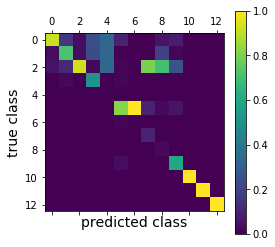

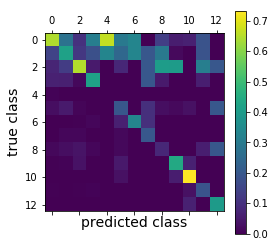

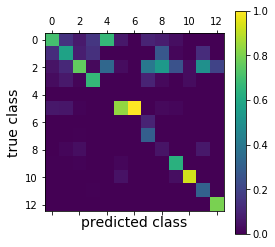

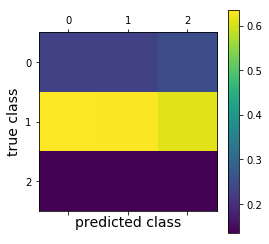

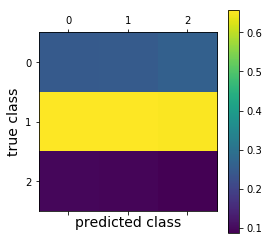

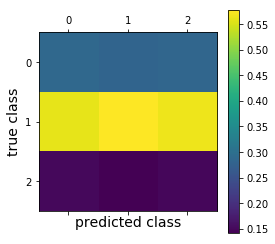

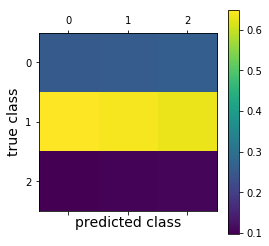

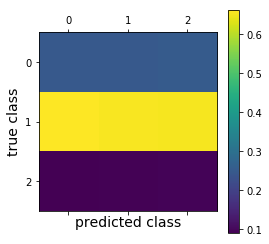

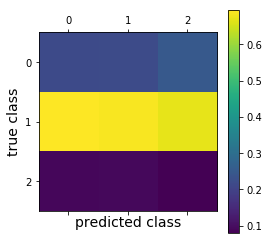

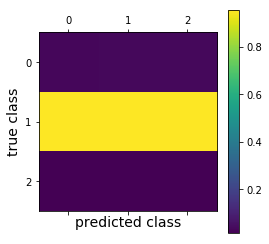

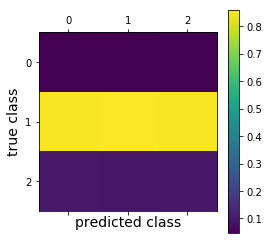

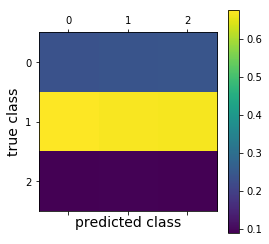

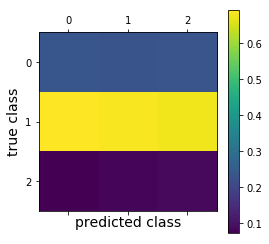

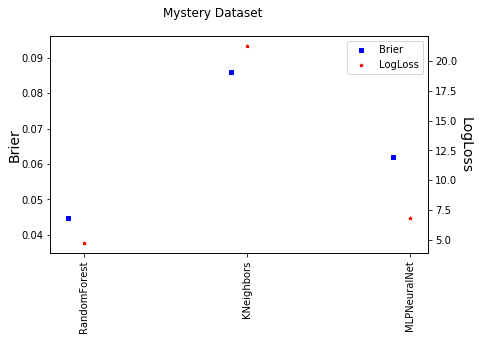

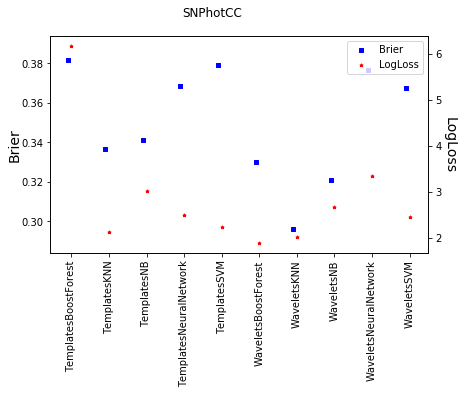

In [10]:

# plt.figure(2, figsize=(10,8))
data = np.empty((len(metricslist), len(names)))
print('data shape'+str(np.shape(data)))
for cc, pair in enumerate(class_pairs):
    print('Using data %s'%names[cc])
    probm, truthv = read_class_pairs(pair)
    for count, metric in enumerate(metricslist):
        print('Using metric %s'%metric)
        D = getattr(proclam.metrics, metric)()
        hm = D.evaluate(probm,truthv)
#         print(hm)
        print('indices'+str((cc, count)))
        data[count][cc] = hm
print(np.shape(data)) 

# plt.figure(2, figsize=(10,8))
more_data = np.empty((len(metricslist), len(more_names)))
print('data shape'+str(np.shape(more_data)))
for cc, pair in enumerate(more_class_pairs):
    print('Using data %s'%more_names[cc])
    probm, truthv = read_class_pairs(pair)
    for count, metric in enumerate(metricslist):
        print('Using metric %s'%metric)
        D = getattr(proclam.metrics, metric)()
        hm = D.evaluate(probm,truthv)
#         print(hm)
        print('indices'+str((cc, count)))
        more_data[count][cc] = hm
print(np.shape(more_data)) 
#         plt.plot(cc, hm, marker=markerlist[count])
        
#     plt.ylabel('Brier score')
#     plt.xlabel('Metrics')
#    ax = pl.gca()
#    ax.set_xticklabels(names)
    #print(cm, tm)
#from proclam.simulators import simulator
#from proclam.simulators import logunbalanced
metric_plot(names, metricslist, data, markerlist, colors, title='Mystery Dataset', fileloc='mysterydata.png')
metric_plot(more_names, metricslist, more_data, markerlist, colors, title='SNPhotCC', fileloc='snphotccdata.png')